# Telco Churn Prediction using k-NN Algorithm

### STEP 1: Import libraries and Load Dataset

In [42]:
# Import libraries and dataset
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

In [43]:
# Load dataset
df = pd.read_csv("Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [44]:
# Inspect dataset
print("Shape: ", df.shape)
df.info()

Shape:  (7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 

##### Quick observations:
1. Mostly categorical features → need encoding.
2. Only a few numeric → scaling will be critical for k-NN.
3. TotalCharges is wrongly typed → needs cleaning.
4. customerID is just an identifier → drop it.
5. Dataset size (~7k) is OK for k-NN, but not huge.

### STEP 2: DATA PREPROCESSING AND EDA

In [45]:
# Target distribution
df["Churn"].value_counts(), df["Churn"].value_counts(normalize=True)

(Churn
 No     5174
 Yes    1869
 Name: count, dtype: int64,
 Churn
 No     0.73463
 Yes    0.26537
 Name: proportion, dtype: float64)

In [46]:
# Drop ID column
df = df.drop(columns="customerID")

In [47]:
# Convert TotalCharges to numeric and fix missing values
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

missing_totalcharges = df["TotalCharges"].isna().sum()
print("Missing TotalCharges count:", missing_totalcharges)

df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

print("Missing after fill:", df["TotalCharges"].isna().sum())


Missing TotalCharges count: 11
Missing after fill: 0


In [48]:
# Encode target as binary
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})
df["Churn"].value_counts(normalize=True)

Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

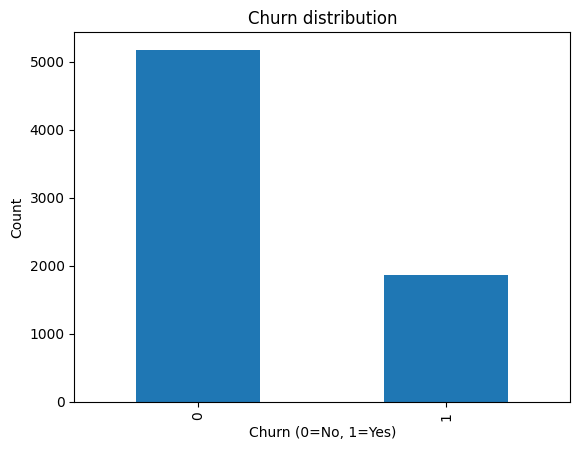

In [49]:
# Visualize class balance on target variable
df["Churn"].value_counts().plot(kind="bar", title="Churn distribution")
plt.xlabel("Churn (0=No, 1=Yes)")
plt.ylabel("Count")
plt.show()

In [50]:
# Check numeric feature differences by churn
df.groupby("Churn")[["tenure", "MonthlyCharges", "TotalCharges"]].mean()


,tenure,MonthlyCharges,TotalCharges
Churn,,,
0,37.569965,61.265124,2552.882494
1,17.979133,74.441332,1531.796094


In [51]:
# Separate features and targets
X = df.drop(columns=["Churn"])
y = df["Churn"]

X.shape, y.shape

((7043, 19), (7043,))

In [52]:
# Identify numeric vs categorical columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object"]).columns.tolist()

print("numerical features are: ", num_features)
print("categorical features (count) are: ", len(cat_features))

numerical features are:  ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
categorical features (count) are:  15


#### STEP 4: Data Splitting

In [53]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Train churn rate:", y_train.mean())
print("Test churn rate:", y_test.mean())


Train shape: (5634, 19)
Test shape: (1409, 19)
Train churn rate: 0.2653532126375577
Test churn rate: 0.2654364797728886


#### STEP 5: Model definition

In [ ]:
# Build data preprocessing pipelines for numeric and categorical data
# k-NN relies on distance 
# scaling numeric features is essential. Categorical must be encoded
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])


In [56]:
# Combine preprocessing with ColumnTransformer
preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_features),
        ("cat", cat_pipe, cat_features)
    ],
    remainder="drop"
)

In [57]:
# Create the full model pipeline
# object handles end-to-end preprocessing and modeling 
pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("knn", KNeighborsClassifier(n_neighbors=5, weights="distance"))
])

pipe

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('prep', ...), ('knn', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains spa

#### STEP 6: Cross-validation baseline (ROC-AUC) 